<a href="https://colab.research.google.com/github/tirals88/pytorch-drl/blob/main/DRL_Chap5_Deep_Q_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***가상환경 구현 및 함수 수정***

In [ ]:
# matplotlib -downgrade

!pip install matplotlib==3.4.2
#호출 후 재시작

In [ ]:
!pip install notebook

In [ ]:
!apt update
!apt install -y xvfb #server install
import sys

IS_COLAB = "google.colab" in sys.modules

if IS_COLAB:
  !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
  %pip install -U tf-agents pyvirtualdisplay
  %pip install -U gym>=0.21.0
  %pip install -U gym[box2d,atari, accept-rom-license]

!xvfb-run -s "-screen 0 1400x900x24" jupyter notebook

### ***display_frames_as_gif 함수 정의***

In [22]:
# 구현에 사용할 패키지 임포트
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

In [23]:
# 애니메이션을 만드는 함수
# 참고 URL : https://github.com/patrickmineault/xcorr-notebooks/blob/master/notebooks/Render%20OpenAI%20gym%20as%20GIF.ipynb
#!pip install JSAnimation
#from JSAnimation.IPython_display import display_animations # error 발생으로 사용하지 않음
from matplotlib import animation
from IPython.display import display

#새로 정의한 display_animtaion 함수

from IPython.display import HTML

In [24]:
def display_animation(anim):
  return HTML(anim.to_jshtml())

In [25]:
def display_frames_as_gif(frames):
  """
  Displays a list of frames as a gif, with controls
  """
  plt.figure(figsize=(frames[0].shape[1]/48.0, frames[0].shape[0]/48.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')

  def animate(i):
    patch.set_data(frames[i])

  anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=20)

  anim.save('movie_cartpole.mp4') #애니메이션을 저장하는 부분
  display(display_animation(anim)) #수정된 부분

In [5]:
try:
  import pyvirtualdisplay
  display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

except ImportError:
  pass

In [6]:
env = gym.make('CartPole-v1')
obs=env.reset()

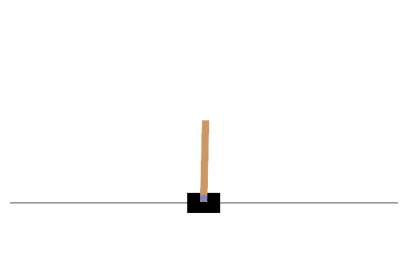

In [7]:
def plot_environment(env, figsize=(5, 4)):
  plt.figure(figsize=figsize)
  img=env.render(mode='rgb_array')
  plt.imshow(img)
  plt.axis('off')
  return img

plot_environment(env)
plt.show()

## 5.1. 딥러닝을 적용한 Q 러닝

### 표형식 표현의 문제점

표형식 표현을 사용하는 $Q$러닝의 문제점은 상태변수의 종류가 늘어나거나 각 변수를 이산변수로 변환할 때 구간을 세세하게 분할하거나 하면 표의 행 수가 크게 늘어난다는 점이다. 예를 들어 이미지를 상태로 받는다면 상태변수는 이미지의 각 픽셀이 될 것이다.

행 수가 많은 표형식 표현으로 제대로 강화학습을 진행하려면 에피소드 수가 매우 많이 필요하다. 이 때문에 상태 수가 많은 태스크는 표형식 표현으로는 제대로 학습시키기가 현실적으로 어렵다.

딥러닝은 이러한 ***상태변수 수가 많아지면 표형식 표현으로는 강화학습이 어렵다***는 문제를 해결하기 위한 것이다.

### 심층강화학습 알고리즘 DQN

상태변수가 많은 태스크에 강화학습을 적용하기 위해 행동가치 함수를 표형식으로 나타내는 대신 층 수가 많은 신경망으로 바꾸어 나타낸다.

각 상태변수의 값을 신경망의 입력으로 삼으며 신경망의 입력층이 갖는 유닛 수는 상태변수의 수와 같다. 역진자 태스크를 예로 들면, 상태는 위치 속도 각도 각속도 4개의 변수이므로 입력 유닛은 4개가 된다.

***신경망에 상태변수를 입력할 때는 이산변수로 변환하는 과정이 필요없다.*** (세세한 구간을 요구하는 것이 아닌 pointwise 하게 변수로 받아들여질 수 있다.)

출력층의 유닛 수는 행동의 가짓수와 같다. 역진자 태스크에서는 좌/우로 미는 행동 두 가지 이다.

출력층 유닛의 출력값은 행동가치 함수의 값이다. 해당 행동을 취했을 때 받을 수 있으리라 예상되는 할인총보상값을 출력하는 것이다. 그리고 출력층 각 유닛이 출력하는 할인총보상값을 비교해보고 행동을 결정한다. 이는 곧 회귀문제에 해당된다.

$Q$ 러닝 알고리즘은 오차 역전파 계산에 사용된다.

### 파이토치로 DQN 구현할 때 주의점

파이토치로 DQN을 구현할 때 주의할 점 5가지가 있다.

첫 번째는 Experience Replay 및 유사 Fixed Target Q-Network를 구현하기 위해 미니 배치 학습을 적용한다는 점이다. DQN은 각 단계의 transition을 메모리 객체에 저장한다. 여기서 transition은 [상태 $s_{t}$, 행동 $a_{t}$, 그 다음 상태 $s_{t+1}$, 그리고 보상 $r_{t+1}$]이 포함된다. 여기서 주의할 점은 봉이 쓰러지거나, 200단계를 버텨내면 게임이 종료되므로 그 다음 단계의 상태 $s_{t+1}$이 존재하지 않는다는 점이다.  이 때문에 다음 상태의 존재 여부에 따라 분기하도록 구현해야 한다.

- 이번 장에서는 편의를 위해 Fixed Target Q-Network를 제대로 구현하는 target Q-Network를 사용하지 않고 그대로 main-network를 사용한다.

두 번째는 파이토치에서 미니배치를 다루는 방법이다.

세 번째는 변수의 데이터 타입이다. CartPole은 NumPy 타입으로 변수를 다루는데, 파이토치에서는 Torch.Tensor 타입으로 된 텐서로 변수를 다룬다.

네 번째는 변수의 크기다. 특히 Torch.Tensor의 크기(dimension)에 주의해야 한다.

다섯 번째는 namedtuple을 사용한다는 점이다. namedtuple을 사용하면 CartPole에서 관측된 상태 변수 값에 이름을 붙여 저장해둘 수 있다.

### DQN 구현

In [8]:
# 이 코드에서는 nmaedtuple 사용
# namedtuple을 사용하면 키-값의 쌍 형태로 값을 저장할 수 있다.
# 그리고 키를 필드명으로 값에 접근할 수 있어 편리하다.
# https://docs.python.org/3/library/collections.html#collections.namedtuple
# 아래는 사용 예다.

from collections import namedtuple

Tr = namedtuple('tr', ('name_a', 'value_b'))
Tr_object = Tr('이름A', 100)

print(Tr_object) # 출력 : tr(name_a='이름A', value_b=100)
print(Tr_object.value_b) # 출력 : 100

tr(name_a='이름A', value_b=100)
100


In [9]:
# namedtuple 생성
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# 상수 정의
ENV = 'CartPole-v0'
GAMMA = 0.99 # 시간할인율
MAX_STEPS = 200 # 1 에피소드 당 최대 단계 수
NUM_EPISODES = 500 # 최대 에피소드 수

미니배치 학습에서 경험 데이터를 저장하는 역할을 할 ReplayMemory 클래스를 정의한다. ReplayMemory 클래스는 각 단계에서 해당 단계의 transition을 저장하는 push 메서드와 무작위로 선택된 transition을 꺼내오는 sample 메서드를 갖추고 있다.

이 클래스는 저장된 transition의 개수가 CAPACITY개를 초과하면 오래된 것부터 지우고 지워진 transition의 인덱스를 새로운 transition에 부여한다.

In [10]:
# transition을 저장하기 위한 메모리 클래스

class ReplayMemory:

  def __init__(self, CAPACITY):
    self.capacity = CAPACITY # 메모리의 최대 저장 건수
    self.memory = [] # 실제 transition을 저장할 변수
    self.index = 0 # 저장 위치를 가리킬 인덱스 변수

  def push(self, state, action, state_next, reward):
    '''transition = (state, action, state_next, reward)을 메모리에 저장'''

    if len(self.memory) < self.capacity:
      self.memory.append(None) # 메모리가 가득 차지 않은 경우

    # Transition이라는 namedtuple을 사용해 키-값 쌍의 형태로 값을 저장
    self.memory[self.index] = Transition(state, action, state_next, reward)

    self.index = (self.index + 1) % self.capacity # 다음 저장할 위치를 한 자리 뒤로 수정

  def sample(self, batch_size):
    '''batch_size 개수만큼 무작위로 저장된 transition을 추출'''
    return random.sample(self.memory, batch_size)

  def __len__(self):
    '''len 함수로 현재 저장된 transition 개수를 반환'''
    return len(self.memory)

다음으로 Brain 클래스를 구현한다. 이 클래스가 DQN 구현의 핵심이 되는 부분이다. 3장에서 구현했던 Q러닝에서는 Brain 클래스가 표 형식으로 나타낸 Q함수를 저장했다. 이번에는 표 대신 신경망으로 Q 함수를 나타낼 것이다. 이 클래스의 메서드는 replay와 decide_action의 2개다. replay 메서드는 메모리 클래스에서 미니배치를 꺼내와서 신경망의 결합 가중치를 학습하는 방법으로 Q 함수를 수정한다.

decide_action 메서드는 $\epsilon$-greedy 알고리즘으로 무작위로 선택된 행동 혹은 현재 상태에서 Q값이 최대가 되는 행동을 선택해서 그 행동의 인덱스 값을 반환한다.

In [15]:
# 에이전트의 두뇌 역할을 하는 클래스. DQN을 실제 수행한다.
# Q 함수를 딥러닝 신경망 형태로 정의한다.

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000

class Brain:
  def __init__(self, num_states, num_actions):
    self.num_actions = num_actions # 행동의 가짓수 (왼쪽, 오른쪽)을 구함

    # transition을 기억하기 위한 메모리 객체 생성
    self.memory = ReplayMemory(CAPACITY)

    # 신경망 구축
    self.model = nn.Sequential()
    self.model.add_module('fc1', nn.Linear(num_states, 32))
    self.model.add_module('relu1', nn.ReLU())
    self.model.add_module('fc2', nn.Linear(32, 32))
    self.model.add_module('relu2', nn.ReLU())
    self.model.add_module('fc3', nn.Linear(32, num_actions))

    print(self.model) # 신경망 구조 출력

    # 최적화 기법 선택

    self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

  def replay(self):
    '''Experience Replay로 신경망의 결합 가중치 학습'''

    # -------------------------------------
    # 1. 저장된 transition 수 확인
    # -------------------------------------
    # 1.1. 저장된 transition의 수가 미니배치 크기보다 작으면 아무것도 하지 않음

    if len(self.memory) < BATCH_SIZE:
      return

    # -------------------------------------
    # 2. 미니배치 생성
    # -------------------------------------
    # 2.1. 메모리 객체에서 미니배치를 추출
    transitions = self.memory.sample(BATCH_SIZE)

    # 2.2. 각 변수를 미니배치에 맞는 형태로 변형
    # transitions는 각 단계 별로 (state, action, state_next, reward) 형태로 BATCH_SIZE
    # 개수만큼 저장됨
    # 다시 말해 (state, action, state_next, reward) * BATCH_SIZE 형태가 된다.
    # 이를 미니배치로 만들기 위해
    # (state*BATCH_SIZE, action*BATCH_SIZE, state_next*BATCH_SIZE, reward*BATCH_SIZE)
    # 형태로 변환한다
    batch = Transition(*zip(*transitions)) ## parameter 를 몇 개 받을 지 모르기 때문

    # 2.3. 각 변수의 요소를 미니배치에 맞게 변형하고, 신경망으로 다룰 수 있게 Variable로 만든다.
    # state를 예로 들면, [torch.FloatTensor of size 1*4] 형태의 요소가 BATCH_SIZE
    # 개수만큼 있는 형태다.
    # 이를 torch.FloatTensor of size BATCH_SIZE*4 형태로 변형한다.
    # 상태, 행동, 보상, non_final 상태로 된 미니배치를 나타내는 Variable을 생성
    # cat 은 Concatenates(연접)을 의미
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])


    # -------------------------------------
    # 3. 정답신호로 사용할 Q(s_t, a_t)를 계산
    # -------------------------------------
    # 3.1. 신경망을 추론 모드로 전환
    self.model.eval()

    # 3.2. 신경망으로 Q(s_t, a_t)를 계산
    # self.model(state_batch)은 왼쪽, 오른쪽에 대한 Q값을 출력하며
    # [torch.FloatTensor of size BATCH_SIZEx2] 형태다.
    # 여기서부터는 실행한 행동 a_t에 대한 Q값을 계산하므로 action_batch에서 취한 행동
    # a_t 가 왼쪽이냐 오른쪽이냐에 대한 인덱스를 구하고, 이에 대한 Q값을 gather 메서드로 모아온다.
    state_action_values = self.model(state_batch).gather(1, action_batch)

    # 3.3 max{Q(s_t+1, a)} 값을 계산한다. 이때 다음 상태가 존재하는지 주의해야 한다.

    # cartpole이 done 상태가 아니고, next_state가 존재하는지 확인하는 인덱스 마스크를 만듬
    non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))

    # 먼저 전체를 0으로 초기화
    next_state_values = torch.zeros(BATCH_SIZE)

    # 다음 상태가 있는 인덱스에 대한 최대 Q값을 구한다.
    # 출력에 접근해서 열방향 최댓값(max(1))이 되는 [값, 인덱스]를 구한다.
    # 그리고 이 Q값(인덱스=0)을 출력한 다음
    # detach 메서드로 이 값을 꺼내온다.
    next_state_values[non_final_mask] = self.model(
        non_final_next_states).max(1)[0].detach()

    # 3.4. 정답신호로 사용할 Q(s_t, a_t) 값을 Q러닝 식으로 계산한다.


    # -------------------------------------
    expected_state_action_values = reward_batch + GAMMA * next_state_values

    # -------------------------------------
    # 4. 결합 가중치 수정
    # -------------------------------------
    # 4.1. 신경망을 학습 모드로 전환
    self.model.train()

    # 4.2. 손실함수를 계산(smooth_l1_loss는 Huber 함수)
    # expected_state_action_values는
    # size가 [minibatch]이므로 unsqueeze해서 [minibatch*1]로 만든다
    loss = F.smooth_l1_loss(state_action_values,
                            expected_state_action_values.unsqueeze(1))

    # 4.3. 결합 가중치를 수정한다
    self.optimizer.zero_grad() # 경사 초기화
    loss.backward() # 역전파 계산
    self.optimizer.step() # 결합 가중치 수정

  def decide_action(self, state, episode):
    '''현재 상태에 따라 행동을 결정한다'''
    # ϵ-greedy 알고리즘에서 서서히 최적행동의 비중을 늘린다.
    epsilon = 0.5 * (1 / (episode + 1))

    if epsilon <= np.random.uniform(0, 1):
      self.model.eval()
      with torch.no_grad():
        action = self.model(state).max(1)[1].view(1, 1)
        # 신경망 출력의 최댓값에 대한 인덱스 = max(1)[1]
        # .view(1, 1) 은 [torch.LongTensor of size 1]을 size 1*1 로 변환하는 역할

    else:
      # 행동을 무작위로 반환 (0 또는 1)
      action = torch.LongTensor(
          [[random.randrange(self.num_actions)]]) # 행동을 무작위로 반환
      # action 은 [torch.LongTensor of size 1*1] 형태가 왼다.

    return action

In [12]:
# CartPole 태스크의 에이전트 클래스. 봉 달린 수레 자체라고 보면 된다


class Agent:
    def __init__(self, num_states, num_actions):
        '''태스크의 상태 및 행동의 가짓수를 설정'''
        self.brain = Brain(num_states, num_actions)  # 에이전트의 행동을 결정할 두뇌 역할 객체를 생성

    def update_q_function(self):
        '''Q함수를 수정'''
        self.brain.replay()

    def get_action(self, state, episode):
        '''행동을 결정'''
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        '''memory 객체에 state, action, state_next, reward 내용을 저장'''
        self.brain.memory.push(state, action, state_next, reward)

In [13]:
# CartPole을 실행하는 환경 역할을 하는 클래스


class Environment:

    def __init__(self):
        self.env = gym.make(ENV)  # 태스크를 설정
        num_states = self.env.observation_space.shape[0]  # 태스크의 상태 변수 수(4)를 받아옴
        num_actions = self.env.action_space.n  # 태스크의 행동 가짓수(2)를 받아옴
        self.agent = Agent(num_states, num_actions)  # 에이전트 역할을 할 객체를 생성


    def run(self):
        '''실행'''
        episode_10_list = np.zeros(10)  # 최근 10에피소드 동안 버틴 단계 수를 저장함(평균 단계 수를 출력할 때 사용)
        complete_episodes = 0  # 현재까지 195단계를 버틴 에피소드 수
        episode_final = False  # 마지막 에피소드 여부
        frames = []  # 애니메이션을 만들기 위해 마지막 에피소드의 프레임을 저장할 배열

        for episode in range(NUM_EPISODES):  # 최대 에피소드 수만큼 반복
            observation = self.env.reset()  # 환경 초기화

            state = observation  # 관측을 변환없이 그대로 상태 s로 사용
            state = torch.from_numpy(np.array(state)).type(
                torch.FloatTensor)  # NumPy 변수를 파이토치 텐서로 변환
            state = torch.unsqueeze(state, 0)  # size 4를 size 1*4로 변환

            for step in range(MAX_STEPS):  # 1 에피소드에 해당하는 반복문

                if episode_final is True:  # 마지막 에피소드에서는 각 시각의 이미지를 frames에 저장한다
                    frames.append(self.env.render(mode='rgb_array'))

                action = self.agent.get_action(state, episode)  # 다음 행동을 결정

                # 행동 a_t를 실행하여 다음 상태 s_{t+1}과 done 플래그 값을 결정
                # action에 .item()을 호출하여 행동 내용을 구함
                observation_next, _, done, _ = self.env.step(
                    action.item())  # reward와 info는 사용하지 않으므로 _로 처리

                # 보상을 부여하고 episode의 종료 판정 및 state_next를 설정한다
                if done:  # 단계 수가 200을 넘었거나 봉이 일정 각도 이상 기울면 done이 True가 됨
                    state_next = None  # 다음 상태가 없으므로 None으로

                    # 최근 10 에피소드에서 버틴 단계 수를 리스트에 저장
                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor(
                            [-1.0])  # 도중에 봉이 쓰러졌다면 페널티로 보상 -1을 부여
                        complete_episodes = 0  # 연속 성공 에피소드 기록을 초기화
                    else:
                        reward = torch.FloatTensor([1.0])  # 봉이 서 있는 채로 에피소드를 마쳤다면 보상 1 부여
                        complete_episodes = complete_episodes + 1  # 연속 성공 에피소드 기록을 갱신
                else:
                    reward = torch.FloatTensor([0.0])  # 그 외의 경우는 보상 0을 부여
                    state_next = observation_next  # 관측 결과를 그대로 상태로 사용
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # numpy 변수를 파이토치 텐서로 변환
                    state_next = torch.unsqueeze(state_next, 0)  # size 4를 size 1*4로 변환

                # 메모리에 경험을 저장
                self.agent.memorize(state, action, state_next, reward)

                # Experience Replay로 Q함수를 수정
                self.agent.update_q_function()

                # 관측 결과를 업데이트
                state = state_next

                # 에피소드 종료 처리
                if done:
                    print('%d Episode: Finished after %d steps：최근 10 에피소드의 평균 단계 수 = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    break

            if episode_final is True:
                # 애니메이션 생성 및 저장
                display_frames_as_gif(frames)
                break

            # 10 에피소드 연속으로 195단계를 버티면 태스크 성공
            if complete_episodes >= 10:
                print('10 에피소드 연속 성공')
                episode_final = True  # 다음 에피소드에서 애니메이션을 생성

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(
<ipython-input-15-8ca0ea6fd4d7>:98: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  next_state_values[non_final_mask] = self.model(


Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 19 steps：최근 10 에피소드의 평균 단계 수 = 1.9
1 Episode: Finished after 15 steps：최근 10 에피소드의 평균 단계 수 = 3.4
2 Episode: Finished after 18 steps：최근 10 에피소드의 평균 단계 수 = 5.2
3 Episode: Finished after 15 steps：최근 10 에피소드의 평균 단계 수 = 6.7
4 Episode: Finished after 13 steps：최근 10 에피소드의 평균 단계 수 = 8.0
5 Episode: Finished after 11 steps：최근 10 에피소드의 평균 단계 수 = 9.1
6 Episode: Finished after 11 steps：최근 10 에피소드의 평균 단계 수 = 10.2
7 Episode: Finished after 11 steps：최근 10 에피소드의 평균 단계 수 = 11.3
8 Episode: Finished after 9 steps：최근 10 에피소드의 평균 단계 수 = 12.2
9 Episode: Finished after 10 steps：최근 10 에피소드의 평균 단계 수 = 13.2
10 Episode: Finished after 10 steps：최근 10 에피소드의 평균 단계 수 = 12.3
11 Episode: Finished after 9 steps：최근 10 에피소드의 평균 단계 수 = 11.7
12 Episode: Finished after 11 step

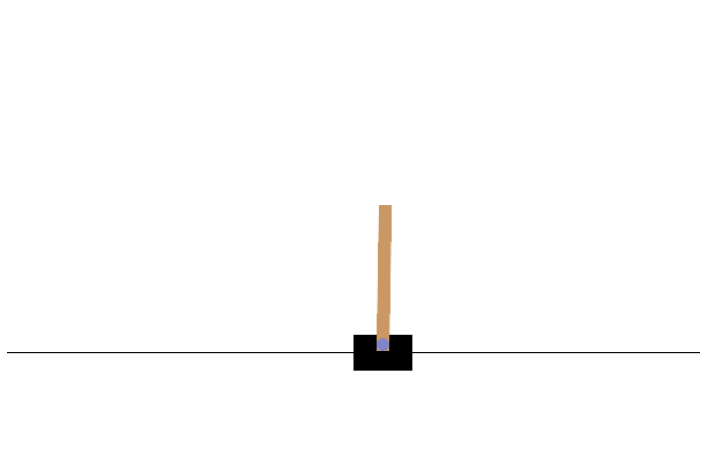

In [26]:
# 실행 엔트리 포인트
cartpole_env = Environment()
cartpole_env.run()

<img width="80%" src="https://github.com/tirals88/pytorch-drl/assets/57607429/7cab7443-43ce-45a9-81be-7dbbc8502eba"/>